## Unit 4 case study - Understanding ARIMA model

### National Mortgage Insurance Stock Market Analysis
Preeti Swaminathan  
06/01/2018


#### Business understanding 
Mortgage Insurance (also known as mortgage guarantee and home-loan insurance) is an insurance policy which compensates lenders or investors for losses due to the default of a mortgage loan. Mortgage insurance can be either public or private depending upon the insurer.

Stock sticker = NMIH  
Full Name: National Mortgage Insurance Holding  
Website: http://www.nationalmi.com/  
Data: From 2014 Jan 1st to 2018 June 1st 


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time
from pandas_datareader import data
import pandas_datareader.data as web
import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [58]:
# Extract data from 2013 thru to 2018
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2018, 6, 1)
nmih = web.DataReader('NMIH', 'iex', start, end)
nmih.index = pd.to_datetime(nmih.index)

5y


#### Data Understanding

Financial data for National MI as as described below. For our analysis we will look into end of trading session value, <b> close</b>

In [59]:
nmih.describe()

,open,high,low,close,volume
count,1112.000000,1112.000000,1112.000000,1112.000000,1.112000e+03
mean,10.074294,10.232531,9.900320,10.065946,3.968732e+05
std,3.529162,3.600632,3.454764,3.529104,5.838269e+05
min,4.380000,4.660000,4.190000,4.410000,6.435000e+03
25%,7.720000,7.850000,7.607500,7.730000,1.557020e+05
50%,9.285000,9.482500,9.145000,9.275000,2.720310e+05
75%,11.612500,11.778750,11.400000,11.585000,4.437852e+05
max,21.650000,21.923600,21.250000,21.700000,1.198662e+07


In [60]:
nmih.head()

,open,high,low,close,volume
date,,,,,
2014-01-02,12.59,12.590,12.090,12.465,12308
2014-01-03,12.52,12.575,12.146,12.260,7473
2014-01-06,12.46,12.500,12.240,12.340,1056189
2014-01-07,12.32,12.490,12.040,12.215,915640
2014-01-08,12.47,12.490,12.120,12.350,83649


In [61]:
nmih.tail()

,open,high,low,close,volume
date,,,,,
2018-05-25,17.25,17.275,16.895,17.00,314381
2018-05-29,16.90,17.200,16.610,17.15,355136
2018-05-30,17.25,17.500,17.150,17.20,443552
2018-05-31,17.20,17.200,16.550,16.65,384680
2018-06-01,16.80,17.100,16.500,16.90,358692


#### Plot of National MI stock price across time

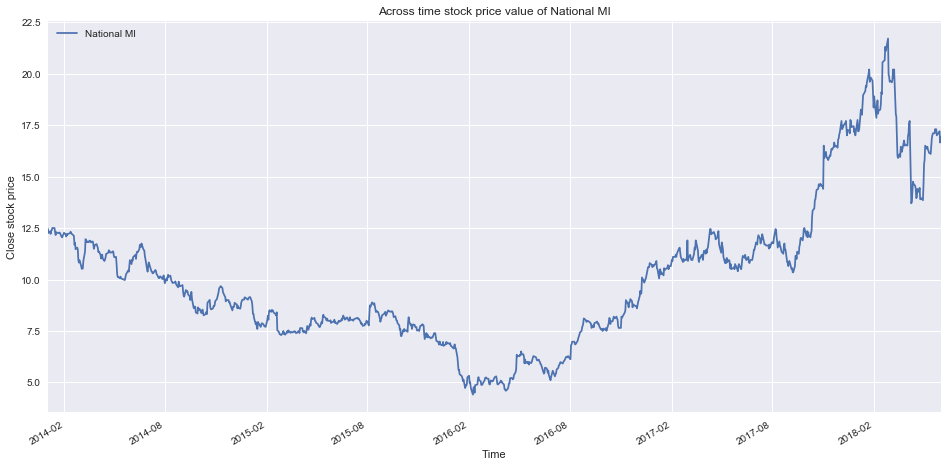

In [62]:
fig = plt.figure()
nmih['close'].plot(figsize=(16,8), label="National MI")
plt.xlabel("Time")
plt.ylabel('Close stock price')
plt.title("Across time stock price value of National MI")
plt.legend()
plt.show()

#### Testing for Stationarity

We can use the Augmented [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [unit root test](https://en.wikipedia.org/wiki/Unit_root_test).

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean  
- constant variance  
- an autocovariance that does not depend on time  

Basically, we are trying to whether to accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

We end up deciding this based on the p-value return.

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.

Let's run the Augmented Dickey-Fuller test on our data:

In [63]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    #plt.plot(figsize=(16,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=90)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


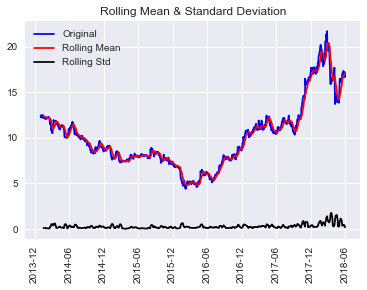

Results of Dickey-Fuller Test:
Test Statistic                   -0.585799
p-value                           0.874159
#Lags Used                        0.000000
Number of Observations Used    1111.000000
Critical Value (1%)              -3.436250
Critical Value (5%)              -2.864145
Critical Value (10%)             -2.568157
dtype: float64


In [64]:
test_stationarity(nmih['close'])

#### Observation
From above summary, p-value > 0.05. Shows weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary. 

#### Differencing to make Time Series stationary
To fix non-stationarity we will create first order difference to make the time series stationary. 

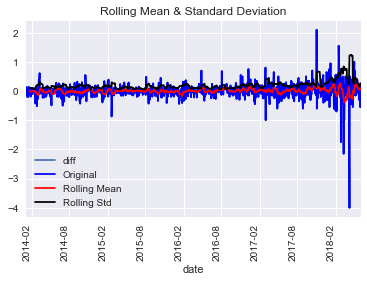

Results of Dickey-Fuller Test:
Test Statistic                  -34.524302
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1110.000000
Critical Value (1%)              -3.436255
Critical Value (5%)              -2.864147
Critical Value (10%)             -2.568158
dtype: float64


In [65]:
nmih['diff']=nmih['close']-nmih['close'].shift(1)
nmih.dropna(inplace=True)
nmih['diff'].plot()
test_stationarity(nmih['diff'])

#### Observation
From above summary, p-value < 0.05. Shows strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary. This is good to build ARIMA model.

### Auto-Correlation and Partial Auto-Correlation plots to identify P,D,Q values

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

ref: https://people.duke.edu/~rnau/411arim3.htm

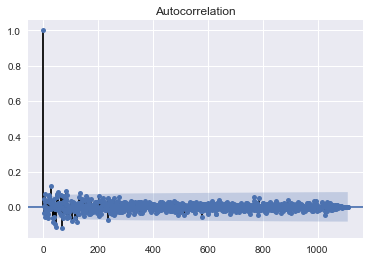

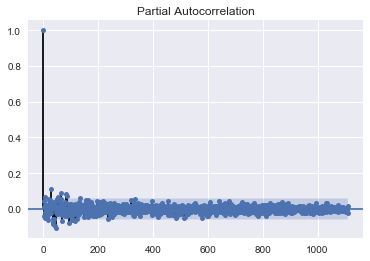

In [66]:
#ACF and PACF plots:
acf_plot = plot_acf(nmih['diff'].dropna())
pacf_plot = plot_pacf(nmih['diff'].dropna())

## ARIMA Model

In [11]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

Arima model requires 3 numbers, p,d,q which describe parameters for AR,MA and differencing.

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

                              ARMA Model Results                              
Dep. Variable:                   diff   No. Observations:                 1064
Model:                     ARMA(1, 0)   Log Likelihood                 178.716
Method:                       css-mle   S.D. of innovations              0.205
Date:                Sat, 02 Jun 2018   AIC                           -351.432
Time:                        18:16:12   BIC                           -336.523
Sample:                    11-11-2013   HQIC                          -345.783
                         - 02-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.006      0.789      0.430      -0.007       0.016
ar.L1.diff    -0.0850      0.031     -2.776      0.006      -0.145      -0.025
                                    Roots           

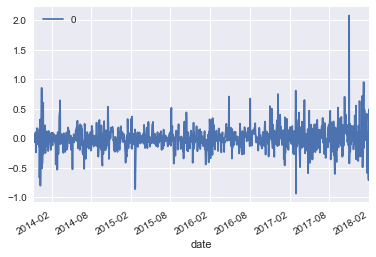

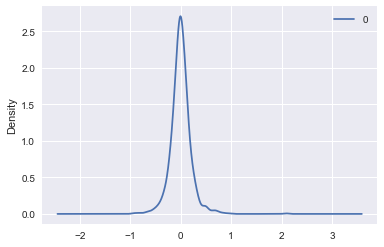

                 0
count  1064.000000
mean      0.000003
std       0.204653
min      -0.936914
25%      -0.100801
50%      -0.004950
75%       0.095211
max       2.082293


In [12]:
model = ARIMA(nmih['diff'], order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

#### Using bruteforce to identify best values of p,d,q



Loss =  6.69650194091


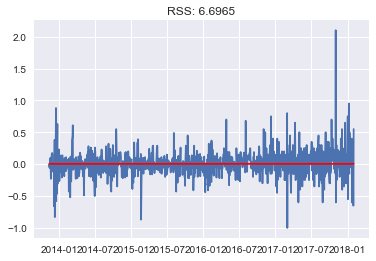

P =  0
D =  0
Q =  0

Loss =  6.67523341285


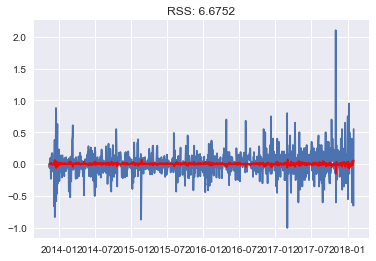

P =  0
D =  0
Q =  1

Loss =  6.65935144713


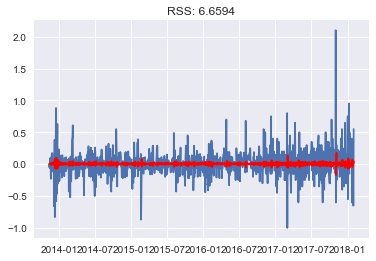

P =  0
D =  0
Q =  2

Loss =  6.65913281579


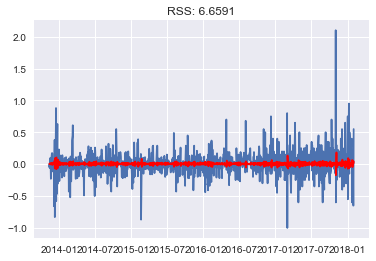

P =  0
D =  0
Q =  3

Loss =  6.65573957922


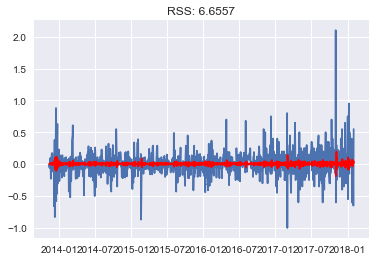

P =  0
D =  0
Q =  4

Loss =  6.63666483771


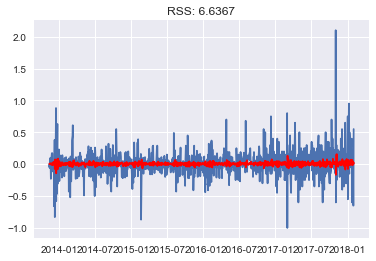

P =  0
D =  0
Q =  5

Loss =  6.63556469772


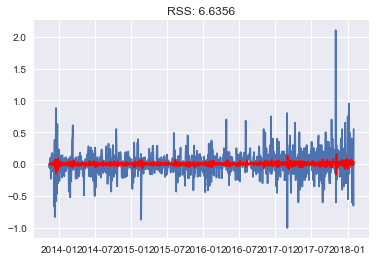

P =  0
D =  0
Q =  6

Loss =  6.61649715108


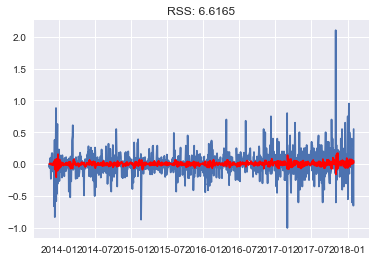

P =  0
D =  0
Q =  7

Loss =  6.61105410704


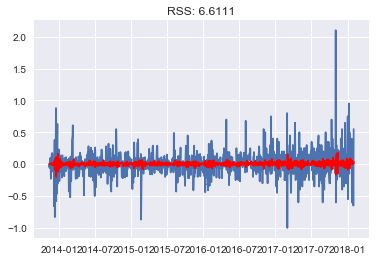

P =  0
D =  0
Q =  8

Loss =  6.60940281565


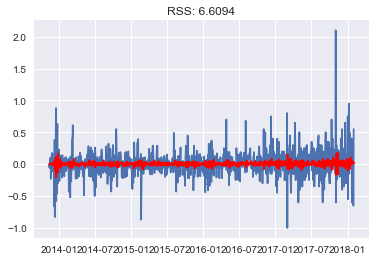

P =  0
D =  0
Q =  9

Loss =  6.6091955362


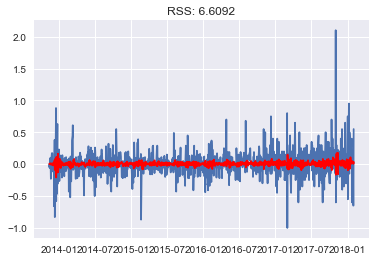

P =  0
D =  0
Q =  10

Loss =  6.60179712788


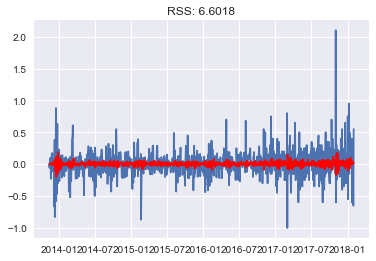

P =  0
D =  0
Q =  11

Loss =  6.5978928021


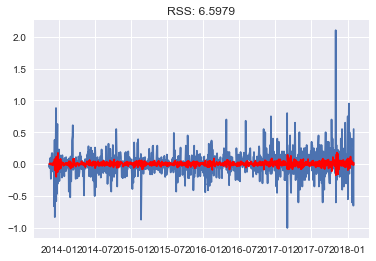

P =  0
D =  0
Q =  12

Loss =  6.59778694222


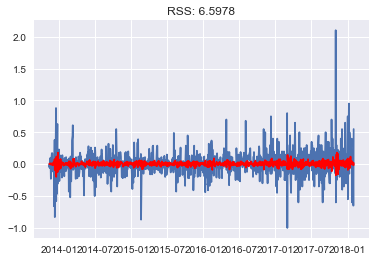

P =  0
D =  0
Q =  13

Loss =  6.59757727196


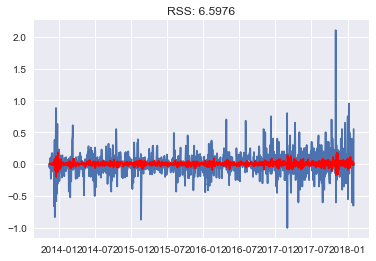

P =  0
D =  0
Q =  14

Loss =  6.59543292466


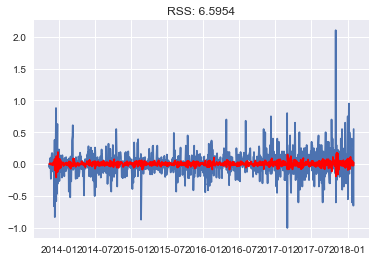

P =  0
D =  0
Q =  15

Loss =  6.59357966091


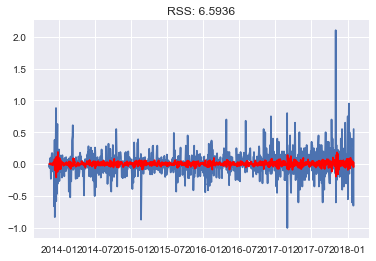

P =  0
D =  0
Q =  16

Loss =  6.57551526376


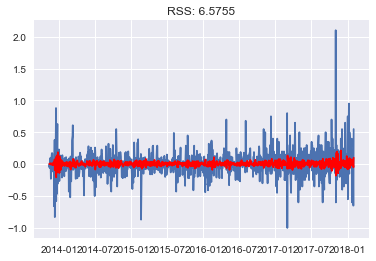

P =  0
D =  0
Q =  17

Loss =  6.57486580978


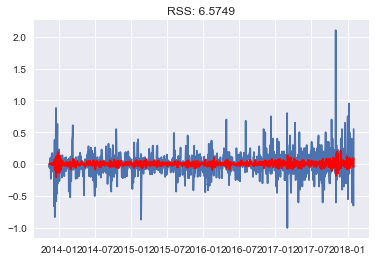

P =  0
D =  0
Q =  18

Loss =  6.57485897152


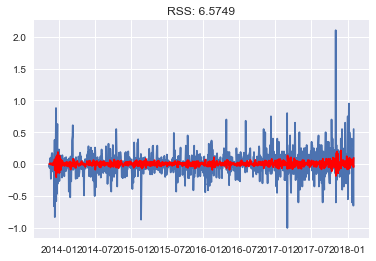

P =  0
D =  0
Q =  19


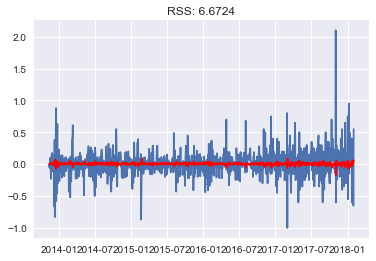

P =  1
D =  0
Q =  0


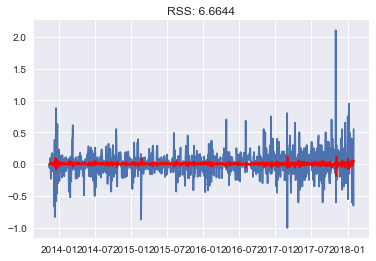

P =  1
D =  0
Q =  1


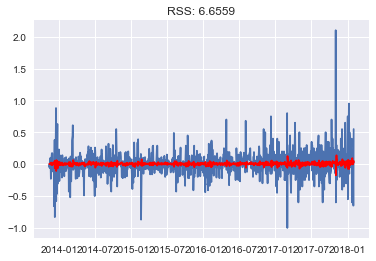

P =  1
D =  0
Q =  2


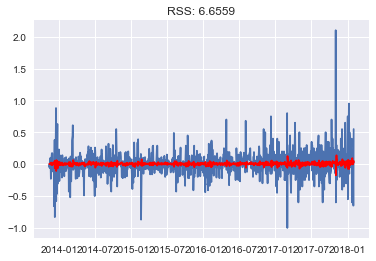

P =  1
D =  0
Q =  3


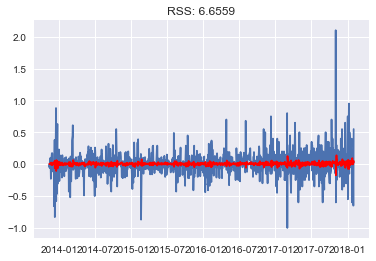

P =  1
D =  0
Q =  4


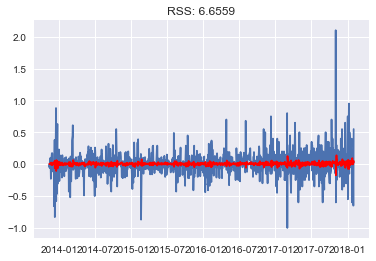

P =  1
D =  0
Q =  5


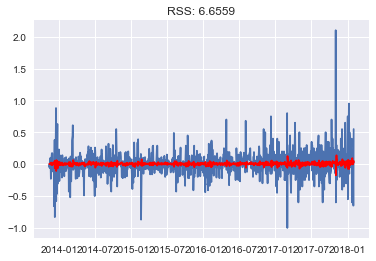

P =  1
D =  0
Q =  6


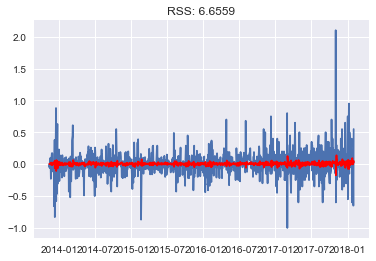

P =  1
D =  0
Q =  7


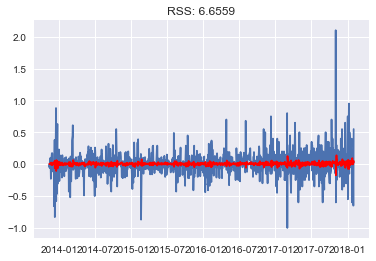

P =  1
D =  0
Q =  8


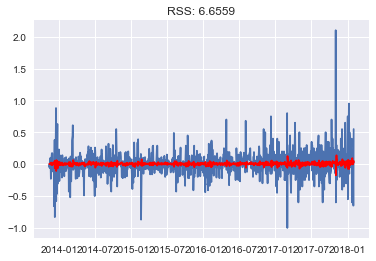

P =  1
D =  0
Q =  9


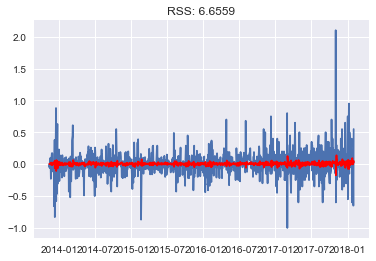

P =  1
D =  0
Q =  10


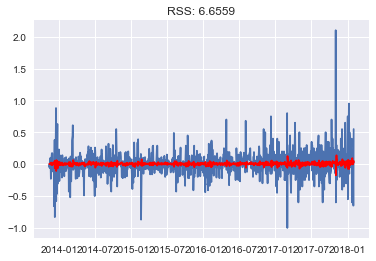

P =  1
D =  0
Q =  11


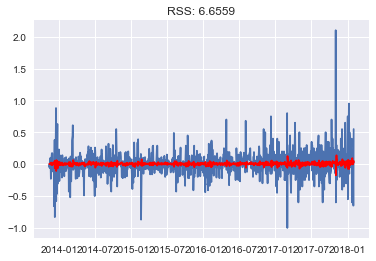

P =  1
D =  0
Q =  12


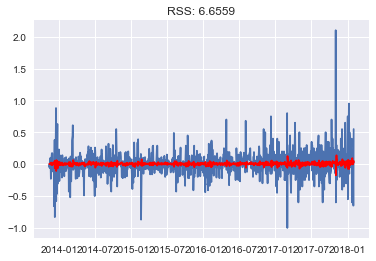

P =  1
D =  0
Q =  13


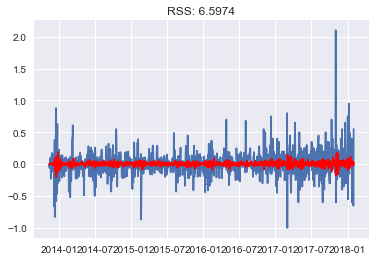

P =  1
D =  0
Q =  14


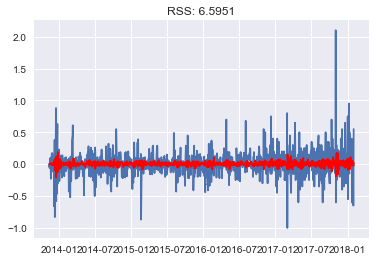

P =  1
D =  0
Q =  15


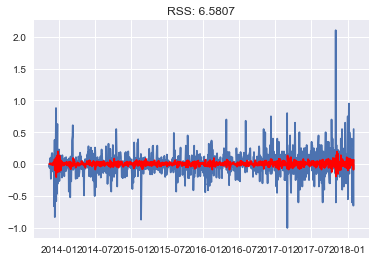

P =  1
D =  0
Q =  16

Loss =  6.57476730052


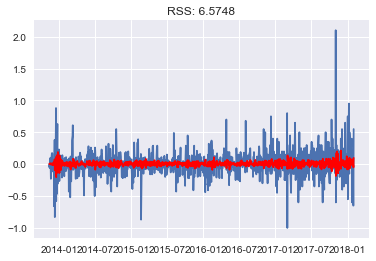

P =  1
D =  0
Q =  17

Loss =  6.5746940042


C:\Users\Preeti\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


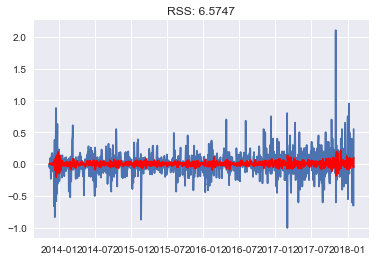

P =  1
D =  0
Q =  18

Loss =  6.57386238127


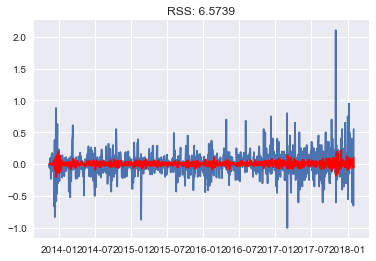

P =  1
D =  0
Q =  19


In [16]:
# set required variables for model comparison
comparison_tbl = pd.DataFrame(columns = [
    'P',
    'D',
    'Q',
    'Loss'])

i_index=[]
i_index = 0

# Calculate p,d,q, loss value
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(2):
    for d in range(1):
        for q in range(20):
            model = ARIMA(nmih['diff'], order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(nmih['diff'])
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(nmih['diff'])
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print("\nLoss = ",loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print("P = ",p)
            print("D = ",d)
            print("Q = ",q)
            raw_data = {
                'P':p,
                'D':d,
                'Q':q,
                'Loss':loss
            }
            df_tbl = pd.DataFrame(raw_data,
                    columns = ['P','D','Q','Loss'],
                    index = [i_index + 1])
            comparison_tbl = comparison_tbl.append(df_tbl)
    
comparison_tbl = comparison_tbl.reset_index(drop=True)

### Model with best parameters

In [17]:
print(loss_best)
print(best_ints)
comparison_tbl

6.57386238127
[1, 0, 19]


,P,D,Q,Loss
0,0,0,0,6.696502
1,0,0,1,6.675233
2,0,0,2,6.659351
3,0,0,3,6.659133
4,0,0,4,6.655740
5,0,0,5,6.636665
6,0,0,6,6.635565
7,0,0,7,6.616497
8,0,0,8,6.611054
9,0,0,9,6.609403


#### Plot Redidual error of each combination of p,d,q

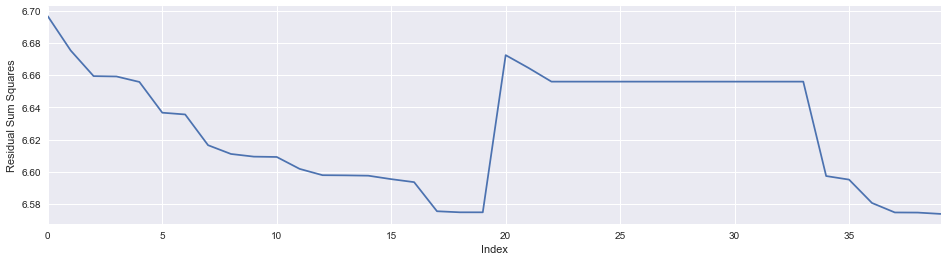

In [24]:
comparison_tbl['Loss'].plot(figsize=(16,4), label="RSS for each p,d,q values")
plt.xlabel("Index")
plt.ylabel("Residual Sum Squares")
plt.show()

From table and plot above, We can see that a Q value or the Moving Average window of 19, P value of 1 and differencing of 1 builds model with least residual error